In [405]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

font_path = 'msjh.ttc'
font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

In [3]:
jieba.set_dictionary('jieba_data/dict.txt.big')
jieba.load_userdict('jieba_data/userdict.txt')
stopwords = []
with open('jieba_data/stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip())
    stopwords.append(' ')

stopwords[:10]

Building prefix dict from C:\Users\CM\Documents\NTU\TA\107 winter\Political-News-Analysis\dict.txt.big ...
Loading model from cache C:\Users\CM\AppData\Local\Temp\jieba.u86db03224454ab6d8bfe857614551ecc.cache
Loading model cost 3.033 seconds.
Prefix dict has been built succesfully.


In [4]:
with open('crawler/data/new_talk.pkl', 'rb') as f:
    data = pickle.load(f)
    
data = data[::-1]
contents = [news['content'] for news in data]

In [874]:
names = []
with open('data/names.txt', 'r', encoding='utf-8-sig') as f:
    names = f.read().split('\n')
    
events = []
with open('data/events.txt', 'r', encoding='utf-8-sig') as f:
    events = f.read().split('\n')

In [6]:
def remove_punctuation(content_string, user_pc=False):
    if(user_pc):
        punctuation = user_pc
    else:
        punctuation=list("!@#$%^&*()_+=-[]`~'\"|/\\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;{}\r\xa0\u3000、，。「」！？；：<>")
        
    for p in punctuation:
        content_string = content_string.replace(p, " ")
    return(content_string)

def remove_stopwords_from_dict(word_dict, stopwords):
    for w in stopwords:
        word_dict.pop(w, word_dict)
    return word_dict

def lcut_to_dict(lcut):
    word_dict = dict(Counter(lcut))
#     word_dict.pop(' ')
    return(remove_stopwords_from_dict(word_dict, stopwords))

def sort_dict_by_values(d):
    return(sorted(d.items(), key=lambda x: x[1], reverse=True))


In [639]:
def news_containing_keyword(keyword, news_list):
    return list(filter(lambda news: keyword in news, news_list))

def data_containing_keyword(keyword, data):
    return list(filter(lambda news: keyword in news['cutted_dict'].keys(), data))

def news_containing_keywords(keywords, news_list):
    news = news_list
    for keyword in keywords:
        news = news_containing_keyword(keyword, news)
        
    return news

In [8]:
# add cutted dict to each news
for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content))
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)
    

## Coshow

In [9]:
# coshow_dict = {}
# cat_content = ' '.join(contents[:100])
# clean_content = remove_punctuation(cat_content)
# cut_content = jieba.lcut(clean_content)
# cut_content = list(filter(lambda x: x!=' ', cut_content))
# for i in range(len(cut_content)-1):
#     wcw = cut_content[i] + cut_content[i+1]
# #     print(wcw)
#     try:
#         coshow_dict[wcw] = coshow_dict[wcw] + 1
#     except:
#         coshow_dict[wcw] = 1

# sdbv = sort_dict_by_values(coshow_dict)
# sdbv

In [10]:
# # output possible words to txt
# import codecs
# list_sdbv = [x[0] for x in sdbv]
# with codecs.open('t.txt', 'w', 'utf-8') as f:
#     f.write('\n'.join(list_sdbv))

## Count words

In [11]:
def get_cutted_dict(list_of_news):
    cat = ' '.join(list_of_news)
    cat = remove_punctuation(cat)
    cutted = jieba.lcut(cat)
    return lcut_to_dict(cutted)

def first_n_words(cutted_dict, n, word_len=2, to=1000):
    sdbv = sort_dict_by_values(cutted_dict)
    return list(filter(lambda x: len(x[0])>=word_len and len(x[0])<=to, sdbv))[:n]

In [12]:
cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 1715),
 ('民進黨', 1026),
 ('中國', 785),
 ('蔡英文', 770),
 ('國民黨', 769),
 ('蘇貞昌', 637),
 ('柯文哲', 615),
 ('臉書', 584),
 ('希望', 582),
 ('媒體', 567),
 ('九二共識', 561),
 ('韓國瑜', 556),
 ('一個', 552),
 ('高雄', 524),
 ('賴清德', 505),
 ('政治', 491),
 ('支持', 481),
 ('指出', 460),
 ('總統', 427),
 ('選舉', 395)]

In [14]:
cutted_dict = get_cutted_dict(contents)

In [866]:
# 可能人名
possible_name = first_n_words(cutted_dict, 1000, 3, 3)

In [813]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200, 4)

## Wordcloud

In [17]:
wc = WordCloud(max_font_size=40,
               background_color="white",
               colormap='Set2',
               font_path=font_path,
               width=1000, height=300,
              max_words=1000)

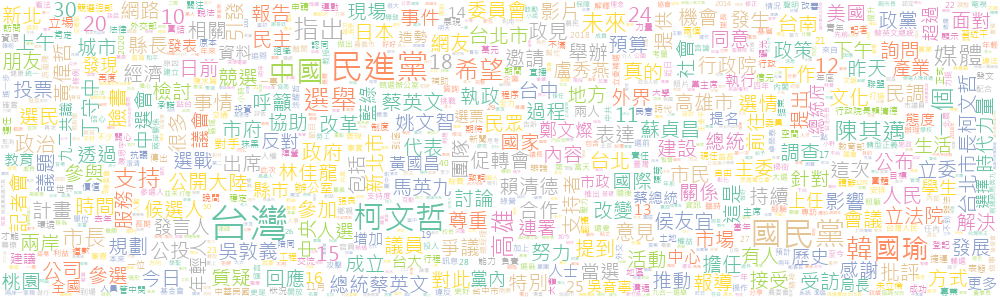

In [18]:
cutted_dict = get_cutted_dict(contents)
high_freq_pair = first_n_words(cutted_dict, 10000)

wc.generate_from_frequencies({word: freq for (word, freq) in high_freq_pair}).to_image()

In [19]:
def get_wordcloud_of_keywords(keywords, list_of_news, image_path=False):
    if type(keywords) == str:
        keywords = [keywords]
    
    if image_path:
        coloring = np.array(Image.open(os.path.join(image_path)))
        color_func = ImageColorGenerator(coloring)
        wc = WordCloud(max_font_size=600,
                       background_color="white",
                       mask=coloring,
                       color_func=color_func,
                       font_path=font_path,
                       width=1000, height=1000,
                      max_words=10000)
    else:
        wc = WordCloud(max_font_size=600,
                       background_color="white",
                       colormap='Set2',
                       font_path=font_path,
                       width=1000, height=300,
                      max_words=1000)
    
    keyword_news = news_containing_keywords(keywords, list_of_news)
    keyword_dict = get_cutted_dict(keyword_news)
    print(len(keyword_dict))
    im = wc.generate_from_frequencies(keyword_dict)
    return im

## 熱門政治人物文字雲

In [601]:
# 蔡英文
# ten_wc = get_wordcloud_of_keywords('蔡英文', contents, 'politicians/ten.png')
# ten_wc.to_file('politicians/tenwc.png')
ten_wc.to_image()

In [413]:
news_containing_ten = news_containing_keyword('蔡英文', contents)
ten_dict = get_cutted_dict(news_containing_ten)
first_n_words(ten_dict, 30)

In [ ]:
# 柯文哲
# kp_wc = get_wordcloud_of_keywords('柯文哲', contents, image_path='politicians/kp.png')
# kp_wc.to_file('politicians/kpwc.png')
kp_wc.to_image()

In [ ]:
news_containing_kp = news_containing_keyword('柯文哲', contents)
kp_dict = get_cutted_dict(news_containing_kp)
first_n_words(kp_dict, 30)

In [ ]:
# 韓國瑜
# han_wc = get_wordcloud_of_keywords('韓國瑜', contents, 'politicians/han.png')
# han_wc.to_file('politicians/hanwc.png')
han_wc.to_image()

In [ ]:
news_containing_han = news_containing_keyword('韓國瑜', contents)
han_dict = get_cutted_dict(news_containing_han)
first_n_words(han_dict, 30)

In [ ]:
# 九二共識
nt_wc = get_wordcloud_of_keyword('九二共識', contents)
nt_wc.to_file('politicians/92.png')
nt_wc.to_image()

In [ ]:
hot = '九二共識'
news_containing_hot = news_containing_keyword(hot, contents)
hot_dict = get_cutted_dict(news_containing_hot)
first_n_words(hot_dict, 30, 3) # 人名

In [ ]:
hotwc = get_wordcloud_of_keywords([hot, '蔡英文'], contents[:1000])
hotwc.to_image()

In [ ]:
hotP = news_containing_keywords([hot, '蔡英文'], contents)
hotP_dict = get_cutted_dict(hotP)
first_n_words(hotP_dict, 30, 2)

In [ ]:
# coloring
# pic_path = 'politicians/kp.png'
# kp_coloring = np.array(Image.open(os.path.join(pic_path)))
# kp_coloring_func = ImageColorGenerator(kp_coloring)

# kpwc = WordCloud(max_font_size=30,
#                background_color="white",
#                mask=kp_coloring,
#                color_func=kp_coloring_func,
#                font_path=font_path,
#                width=1000, height=1000)

## defining events

In [718]:
def merge_one_day_news_dict(one_day_dict, count='wt', divide = 1):
    all_words = set([word for each_dict in one_day_dict for word in each_dict])
    one_day_wf = {}
    for word in all_words:
        one_day_wf[word] = 0
        for news in one_day_dict:
            if count == 'wt':
                one_day_wf[word] += news.get(word, 0)/divide
            if count == 'occur':
                one_day_wf[word] += bool(news.get(word, 0))/divide
    
    return one_day_wf

In [625]:
date_list = [news['date'] for news in data]
all_date = sorted(list(set(date_list)))
date_index = [date_list.index(each_date) for each_date in all_date]
date_index.append(len(date_list)-1)
number_of_news = [date_index[i+1] - date_index[i]-1 for i in range(len(date_index)-1)]
number_of_terms = [sum([sum(data[ni]['cutted_dict'].values()) for ni in range(date_index[i], date_index[i+1])]) for i in range(len(date_index)-1)]

In [22]:
# 每日詞數
wn_by_day = {}
for i in range(len(date_index)-2, -1, -1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict)
#     print(all_date[i])
    wn_by_day[all_date[i]] = current_word_dict

In [692]:
[e['date'] for e in event_data]
all_date.index('2018-11-28')

174

In [23]:
# 每日詞頻
tf_by_day = {}
for i in range(len(date_index)-2, -1, -1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, divide=number_of_terms[i])
#     print(all_date[i])
    tf_by_day[all_date[i]] = current_word_dict

In [24]:
# 每天出現的字
occur_by_day = {}
for i in range(len(date_index)-2, -1, -1):
    oneday_news = data[date_index[i]: date_index[i+1]]
    oneday_dict = [news['cutted_dict'] for news in oneday_news]
    current_word_dict = merge_one_day_news_dict(oneday_dict, count='occur', divide=number_of_news[i])
#     print(all_date[i])
    occur_by_day[all_date[i]] = current_word_dict

In [25]:
def first_n_wf_by_day(wf_by_day, n, word_len=2, to=1000):
    return {day: dict(first_n_words(wf_by_day[day], n, word_len=word_len, to=to)) for day in wf_by_day}

In [151]:
first_10_wf_by_day = first_n_wf_by_day(tf_by_day, 10, 2)
first_5_wf_by_day = first_n_wf_by_day(tf_by_day, 5, 2)

In [ ]:
df1 = pd.DataFrame(first_10_wf_by_day)
df2 = pd.DataFrame(first_5_wf_by_day)

In [27]:
df = pd.DataFrame(wn_by_day)
df = df.fillna(0)

In [28]:
df_tf = pd.DataFrame(tf_by_day)
df_tf = df_tf.fillna(0)

In [29]:
df_occur = pd.DataFrame(occur_by_day)
df_occur = df_occur.fillna(0)

In [30]:
aall_date = [date[5:] for date in all_date][::-1]
aall_date

['06-07',
 '06-08',
 '06-09',
 '06-10',
 '06-11',
 '06-12',
 '06-13',
 '06-14',
 '06-15',
 '06-16',
 '06-17',
 '06-18',
 '06-19',
 '06-20',
 '06-21',
 '06-22',
 '06-23',
 '06-24',
 '06-25',
 '06-26',
 '06-27',
 '06-28',
 '06-29',
 '06-30',
 '07-01',
 '07-02',
 '07-03',
 '07-04',
 '07-05',
 '07-06',
 '07-07',
 '07-08',
 '07-09',
 '07-10',
 '07-11',
 '07-12',
 '07-13',
 '07-14',
 '07-15',
 '07-16',
 '07-17',
 '07-18',
 '07-19',
 '07-20',
 '07-21',
 '07-22',
 '07-23',
 '07-24',
 '07-25',
 '07-26',
 '07-27',
 '07-28',
 '07-29',
 '07-30',
 '07-31',
 '08-01',
 '08-02',
 '08-03',
 '08-04',
 '08-05',
 '08-06',
 '08-07',
 '08-08',
 '08-09',
 '08-10',
 '08-11',
 '08-12',
 '08-13',
 '08-14',
 '08-15',
 '08-16',
 '08-17',
 '08-18',
 '08-19',
 '08-20',
 '08-21',
 '08-22',
 '08-23',
 '08-24',
 '08-25',
 '08-26',
 '08-27',
 '08-28',
 '08-29',
 '08-30',
 '08-31',
 '09-01',
 '09-02',
 '09-03',
 '09-04',
 '09-05',
 '09-06',
 '09-07',
 '09-08',
 '09-09',
 '09-10',
 '09-11',
 '09-12',
 '09-13',
 '09-14',


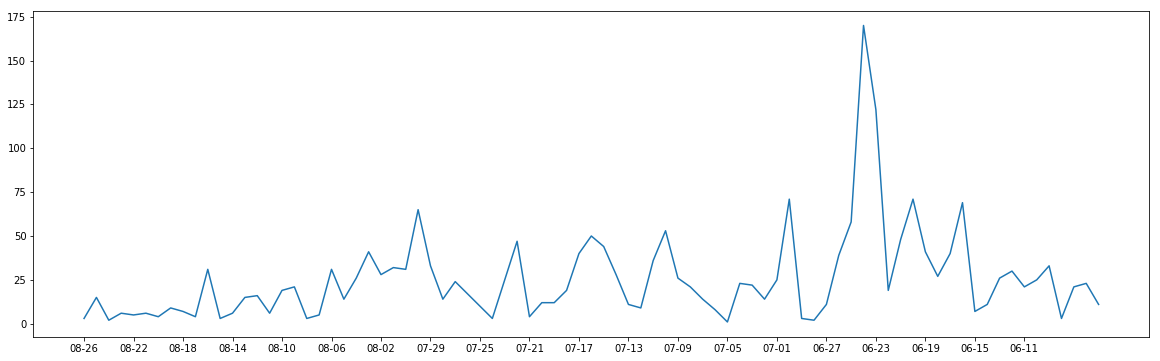

In [569]:
# word times
plt.figure(figsize=(20,6))
plt.plot(aall_date[147:], df.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.show()

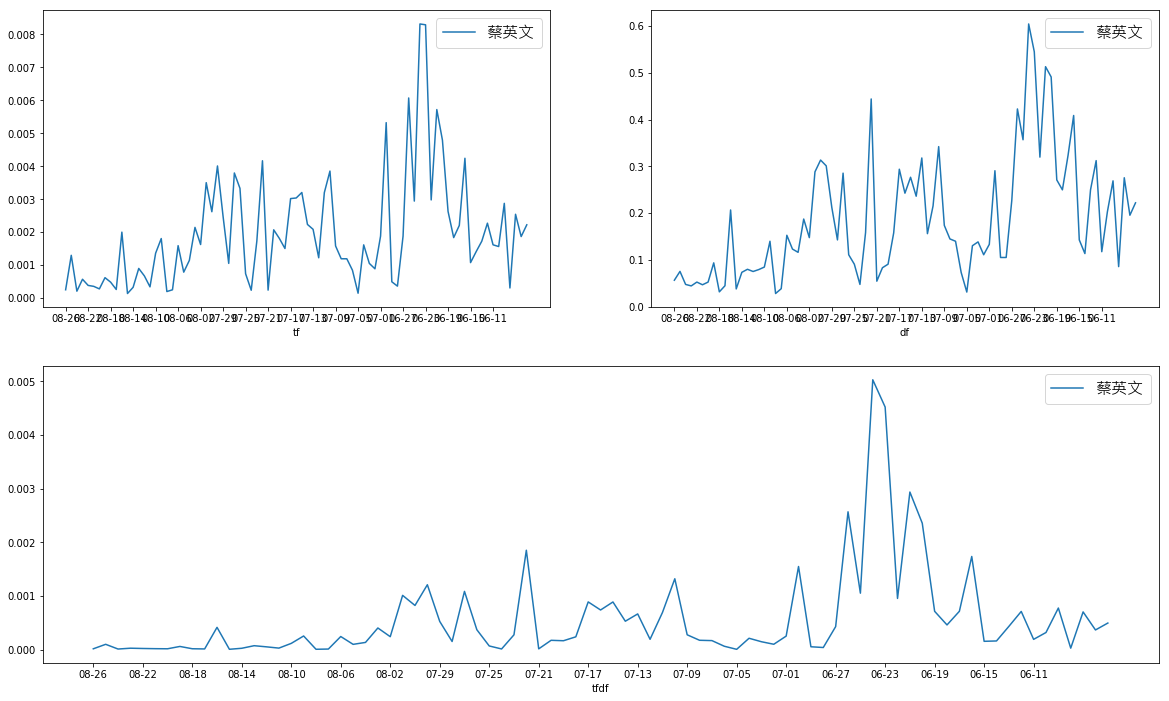

In [158]:
plt.figure(figsize=(20,12))

font = font_manager.FontProperties(fname='msjh.ttc',
                               weight='bold',
                               style='normal', size=16)

plt.subplot(221)
plt.plot(aall_date[147:], df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tf')

plt.subplot(222)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('df')

plt.subplot(212)
plt.plot(aall_date[147:], df_occur.loc['蔡英文']['2018-11-01':]*df_tf.loc['蔡英文']['2018-11-01':], label='蔡英文')
plt.xticks(list(range(0, 80, 4)), [aall_date[-150::-1][i] for i in range(0, 80, 4)])
plt.legend(prop=font)
plt.xlabel('tfdf')

plt.show()

In [260]:
def plot_line_of_word(word, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df.columns.get_loc(date_from)
    to_index = df.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], df.loc[word][date_from:date_to], '--o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])
    
def plot_tfdf_of_word(word, date_from='2018-06-07', date_to='2019-01-22'):
    from_index = df.columns.get_loc(date_from)
    to_index = df.columns.get_loc(date_to)+1
    date_length = to_index-from_index
    date_int = date_length//25
    font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)
    
    plt.plot(aall_date[from_index:to_index], 
             df_tf.loc[word][date_from:date_to]*df_occur.loc[word][date_from:date_to], '--o', label=word)
    plt.legend(prop=font)
    plt.xticks(list(range(0, date_length, date_int)), [aall_date[from_index:to_index][i] for i in range(0, date_length, date_int)])


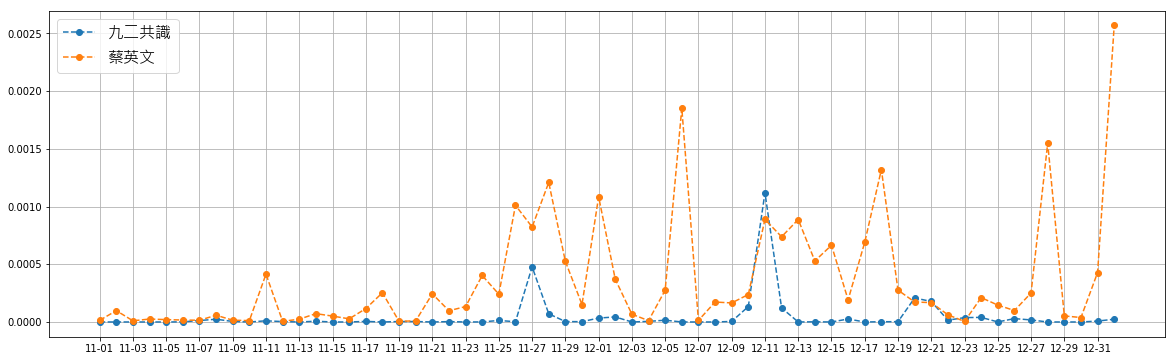

In [186]:
plt.figure(figsize=(20,6))
# plot_line_of_word('九二共識', date_from='2018-11-01', date_to='2019-01-01')
# plot_line_of_word('蔡英文', date_from='2018-11-01', date_to='2019-01-01')

plot_tfdf_of_word('九二共識', date_from='2018-11-01', date_to='2019-01-01')
plot_tfdf_of_word('蔡英文', date_from='2018-11-01', date_to='2019-01-01')

plt.grid()
plt.show()

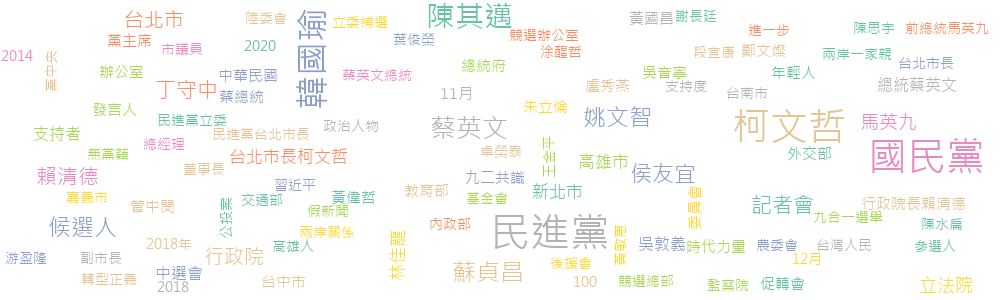

In [36]:
hot3 = first_n_words(cutted_dict, 100, 3)
hot3l = [x[0] for x in hot3]
wc.generate_from_frequencies(dict(hot3)).to_image()

In [40]:
peak_bool = [x>6 for x in tfdf_ratio("蔡英文")]
peak_date = [aall_date[x[0]] for x in list(filter(lambda e: e[1], enumerate(peak_bool)))]
sum(peak_bool)
# peak_date

22

In [444]:
with open('aa.txt', 'w') as f:
    f.write('\n'.join(hot4hot))

In [439]:
hot4 = [x[0] for x in first_n_words(cutted_dict, 100, 4)]
hot4_500 = [x[0] for x in first_n_words(cutted_dict, 500, 4)]

In [854]:
def get_tfdf(word):
    tfdf = df_occur.loc[word] * df_tf.loc[word]
    return tfdf

In [521]:
def get_high_tfdf_date(word):
    tfdf = df_occur.loc[word] * df_tf.loc[word]
    m = statistics.mean(tfdf)
    s = statistics.stdev(tfdf)
    tfdf_bool = [x > m+s for x in tfdf]
    tfdf_date = {all_date[x[0]]: tfdf[x[0]] for x in list(filter(lambda e: e[1], enumerate(tfdf_bool)))}
    return tfdf_date

In [429]:
hot3 = [x[0] for x in first_n_words(cutted_dict, 100, 3, 3)]
hot3
hot3_date = {word: get_high_tfdf_date(word) for word in hot3}

['民進黨',
 '國民黨',
 '柯文哲',
 '韓國瑜',
 '陳其邁',
 '蔡英文',
 '蘇貞昌',
 '姚文智',
 '候選人',
 '侯友宜',
 '丁守中',
 '賴清德',
 '記者會',
 '台北市',
 '行政院',
 '馬英九',
 '立法院',
 '高雄市',
 '林佳龍',
 '新北市',
 '吳敦義',
 '中選會',
 '支持者',
 '促轉會',
 '委員會',
 '黃偉哲',
 '盧秀燕',
 '發言人',
 '鄭文燦',
 '年輕人',
 '黃國昌',
 '總統府',
 '蔡總統',
 '吳音寧',
 '辦公室',
 '11月',
 '台中市',
 '黨主席',
 '朱立倫',
 '教育部',
 '管中閔',
 '外交部',
 '習近平',
 '陳水扁',
 '基金會',
 '支持度',
 '參選人',
 '卓榮泰',
 '進一步',
 '涂醒哲',
 '游盈隆',
 '陳思宇',
 '總經理',
 '市議員',
 '農委會',
 '嘉義市',
 '王金平',
 '陸委會',
 '董事長',
 '12月',
 '副市長',
 '黨中央',
 '假新聞',
 '交通部',
 '100',
 '後援會',
 '無黨籍',
 '監察院',
 '葉俊榮',
 '段宜康',
 '高雄人',
 '黃敏惠',
 '台南市',
 '謝長廷',
 '內政部',
 '公投案',
 '蔡政府',
 '新竹縣',
 '秘書長',
 '高思博',
 '第一次',
 '主持人',
 '有沒有',
 '越來越',
 '桃園市',
 '黨產會',
 '總幹事',
 '大巨蛋',
 '中常會',
 '婦聯會',
 '高嘉瑜',
 '國防部',
 '嘉義縣',
 '500',
 '中生代',
 '黃信介',
 '理事長',
 '中國人',
 '何志偉',
 '公務員']

In [378]:
hot4_date = {word: get_high_tfdf_date(word) for word in hot4}

In [423]:
def keyword_with_event(keyword):
    news_containing_key = news_containing_keyword(keyword, contents)
    key_dict = get_cutted_dict(news_containing_key)
    key_term = first_n_words(key_dict, 300)
    return list(filter(lambda x: x in hot4, [x[0] for x in key_term]))


In [795]:
def draw_event(event, i):
    event_date = get_high_tfdf_date(event)
    date_index = [all_date.index(x) for x in event_date.keys()]
    plt.scatter(date_index, [i for x in date_index], s=[x*100000 for x in list(event_date.values())])
    
def draw_by_list(tf_list, i):
    plt.scatter(aall_date, [i for x in aall_date], s=[x*10 for x in tf_list])

In [575]:
event_high_tfdf_dict = {e: get_high_tfdf_date(e) for e in events}

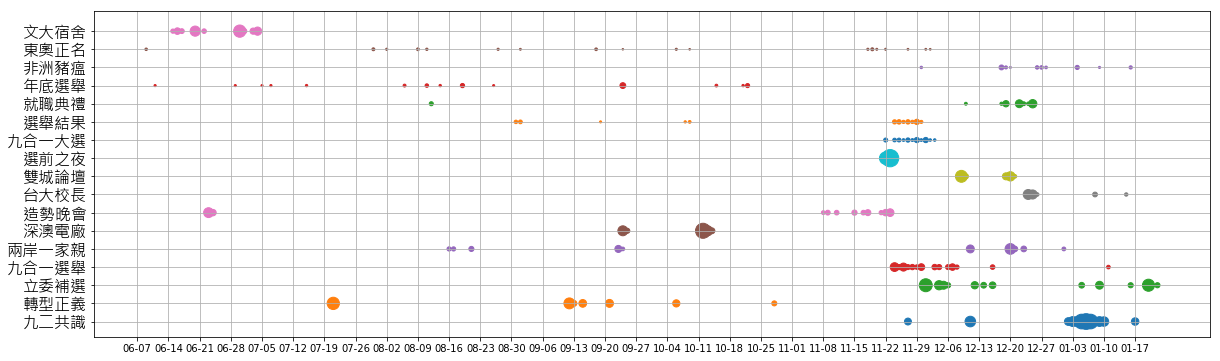

In [540]:
plt.figure(figsize=(20, 6))
for (i, e) in enumerate(events):
    draw_event(e, i)
# plt.xticks(range(0, 230), all_date)
plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, 17), events, fontproperties=font)

plt.grid()
plt.show()

In [850]:
# each event with tfdf of related people
event_people_dict = {}
for event in events:
    event_data = data_containing_keyword(event, data)
    # event_data[0]
    name_times_of_date = {}
    for date in all_date:
        oneday_data = list(filter(lambda data: data['date']==date, event_data))
        oneday_dict = [news['cutted_dict'] for news in oneday_data]
        current_word_dict = merge_one_day_news_dict(oneday_dict, 'wt', divide=len(oneday_data))
        possible_name = first_n_words(current_word_dict, 10000, 3, 3)
        name_times_of_date[date]= list(filter(lambda x: x[0] in names, possible_name))

    all_names = set([name for name_list in name_times_of_date.values() for (name, times) in name_list])
    event_people_dict[event] = {name: [dict(name_times_of_date[date]).get(name, 0) for date in all_date] for name in all_names}
    
with open('event_people_dict.json', 'w', encoding='utf-8') as j:
    json.dump(event_people_dict, j)

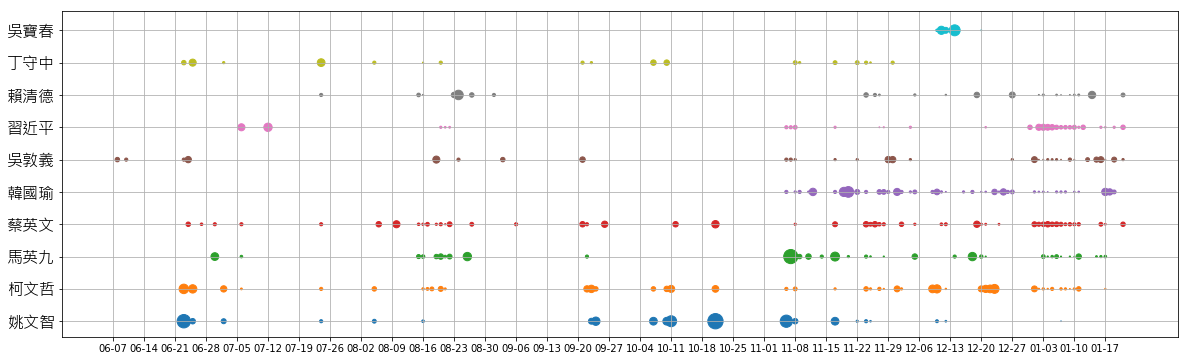

In [807]:
event_people_dict = dict(sorted(event_people_dict.items(), key=lambda x: sum(x[1]), reverse=True)[:10])

plt.figure(figsize=(20, 6))
for (i, people) in enumerate(event_people_dict):
    draw_by_list(event_people_dict[people], i)

plt.xticks(list(range(0, 230, 7)), [aall_date[i] for i in range(0, 230, 7)])
plt.yticks(range(0, len(event_people_dict)), [people for people in event_people_dict], fontproperties=font)
    
plt.grid()
plt.show()

In [875]:
people_tfdf_dict = {name: list(get_tfdf(name)) for name in names}

In [877]:
with open('people_tfdf_dict.json', 'w', encoding='utf-8') as j:
    json.dump(people_tfdf_dict, j)

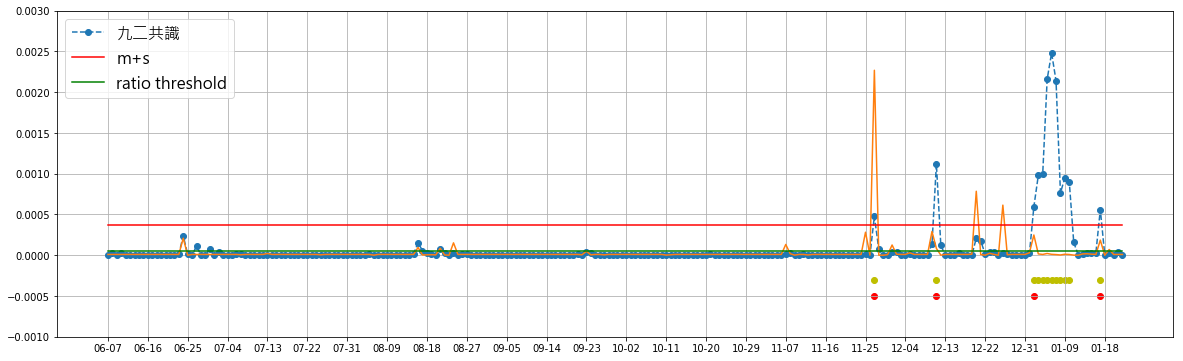

In [375]:
font = font_manager.FontProperties(fname='msjh.ttc',
                                   weight='bold',
                                   style='normal', size=16)

ratio = tfdf_ratio(word)
plt.figure(figsize=(20, 6))
plot_tfdf_of_word(word)
plt.grid()
a = [x*0.00001 for x in ratio]
plt.plot(aall_date, a)
plt.scatter(peak_date, [-0.0005 for i in range(len(peak_date))], c='r')
plt.scatter(tfdf_date, [-0.0003 for i in range(len(tfdf_date))], c='y')
plt.plot(aall_date, [m+s for i in aall_date], 'r-', label='m+s')
plt.plot(aall_date, [0.00005 for i in aall_date], 'g-', label='ratio threshold')

plt.ylim((-0.001, 0.003))
plt.legend(prop=font)
plt.show()

## TFIDF

In [315]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [325]:
ccontents = [remove_punctuation(news) for news in contents]

In [326]:
corpus = [' '.join(jieba.lcut(news)) for news in ccontents]

In [327]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
word = vectorizer.get_feature_names()

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

In [328]:
pd.DataFrame(tfidf.toarray(), columns=word)

,00,000,0000,0001,0005030960009,001,0015,002,003,0039,...,龜山,龜山島,龜崙嶺,龜王,龜笑,龜縮,龜苓,龜苓膏,龜裂,龜速
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
